## COMP5625M Assessment 1 - Image Classification [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected images from section 6 "Failure/success analysis" (outputs from gradcam, for example you can put these images into failure and succcess folders).

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.



Your student username (for example, ```sc15jb```):

sc22qh

Your full name:

QiuYuan Han

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [5]:
import math
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import torchvision.datasets as datasets
from PIL import Image
from torchvision.datasets import ImageFolder
from natsort import natsorted
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader


from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import pickle

In [6]:
# always check your version
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.13.1+cu116
Using device: cpu


In [7]:
from google.colab import drive
drive.mount('/content/drive')
# mounted on MyDrive
!ls '/content/drive/'

Mounted at /content/drive
MyDrive


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** (12 marks)

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (4 marks)

**2. Model training** (20 marks)
*   **2.1** Train on TinyImageNet30 dataset (7 marks)
*   **2.2** Generate confusion matrices and ROC curves (4 marks)
*   **2.3** Strategies for tackling overfitting (9 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** (20 marks)
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) (8 marks)
*   **3.2** Fine-tune model with frozen base convolution layers (8 marks)
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? (4 marks) 

**4. Model testing** (18 marks)
*   **4.1**   Test your final model in (2) on test set - code to do this (10 marks)
*   **4.2**   Upload your result to Kaggle  (8 marks)

**5. Model comparison** (14 marks)
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (6 marks)
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks)

**6. Interpretation of results** (16 marks)
*   **6.1** Use grad-CAM on your model and on AlexNet (6 marks)
*   **6.2** Visualise and compare the results from your model and from AlexNet (4 marks)
*   **6.3** Comment on (6 marks):
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations [12 marks]


### 1.1 Dataset class [4 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [8]:

transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])
ROOT="/content/drive/MyDrive/DeepLearing/comp5625M_data_assessment_1/"



In [9]:
train_dataset = ImageFolder(root=ROOT+"train_set/train_set",transform=transform)
train_set,val_set = torch.utils.data.random_split(train_dataset,[0.8,0.2])
train_loader = DataLoader(train_set,batch_size=16,shuffle=True)
val_loader = DataLoader(val_set,batch_size=24,shuffle=True)

# iterator_marks=iter(dataloader)

In [ ]:
# test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [ ]:
img=next(iter(test_loader))[0]
print(img.shape)
img=img.to(device)
cnn(img)

torch.Size([1, 3, 64, 64])


tensor([[-0.1134, -0.1250, -0.0711,  0.0700,  0.0911, -0.1077, -0.0446,  0.0259,
          0.0444,  0.0103, -0.0449, -0.0367,  0.0770,  0.0965, -0.1204, -0.0779,
         -0.0408,  0.0613, -0.0182,  0.0047, -0.0370,  0.0638, -0.0878, -0.0513,
         -0.0930,  0.0323,  0.0825,  0.0139, -0.0005,  0.0110]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# for data in train_loader:
#   images,labels=data
# # input_T=next(iterator_marks)[0][0]
#   img=images[0]
#   print(images[0].shape)
#   break
# # print(next(iterator_marks))
# # print(next(iter(dataloader))) # prints shape of image with single batch

torch.Size([3, 64, 64])


### 1.2 Define a MLP model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
# TO COMPLETE
# define a MLP Model class
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        # single layer
        nn.Linear(3*64*64,256),
        nn.Sigmoid(),
        nn.Linear(256,128),
        nn.Sigmoid(),
        nn.Linear(128,30)
    )
  def forward(self, x):
    return self.layers(x)
mlp=MLP()
print(mlp)
params=list(mlp.parameters())
print(len(params))
print(params[0].size())

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=256, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=128, out_features=30, bias=True)
  )
)
6
torch.Size([256, 12288])


In [ ]:
# TO COMPLETE
# define a MLP Model class
class MLP_LTS(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        # single layer
        nn.Linear(3*64*64,128),
        nn.Sigmoid(),
        nn.Linear(128,30)
    )
  def forward(self, x):
    return self.layers(x)
mlp_lts=MLP_LTS()
print(mlp_lts)
params=list(mlp_lts.parameters())
print(len(params))
print(params[0].size())

MLP_LTS(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=128, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=128, out_features=30, bias=True)
  )
)
4
torch.Size([128, 12288])


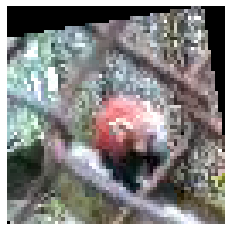

In [ ]:

# # img=images[0].reshape(3,64,64)
# img_show=np.transpose(img.numpy(),(1,2,0))
# plt.imshow(img_show)
# plt.axis('off')
# plt.show()
# # print(labels)

In [ ]:
# mlp_pred=mlp(images)
# print(mlp_pred)

tensor([[-0.1302, -0.1483, -0.2087, -0.2909,  0.4258, -0.1031, -0.0843, -0.6124,
          0.4313,  0.0219, -0.4726,  0.0257, -0.1230,  0.0494,  0.3465, -0.3243,
         -0.1176, -0.1224, -0.6149,  0.1777,  0.2565,  0.5846, -0.2883, -0.0370,
          0.2063,  0.4122,  0.0747,  0.9031, -0.3483,  0.1281]],
       grad_fn=<AddmmBackward0>)


### 1.3 Define a CNN model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [ ]:
# TO COMPLETE
# define a CNN Model class
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*13*13,64),     # with 32x32 input, the feature map size reduces to 5x5 with 16 channels.
        nn.ReLU(),
        nn.Linear(64,30)
    )
  def forward(self, x):
    return self.layers(x)
# cnn=CNN()
# print(cnn)
# params=list(cnn.parameters())
# print(len(params))
# print(params[0].size())

In [30]:
# TO COMPLETE
# define a CNN Model class
class CNN_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3),    # no padding, stride=1, dilation=1 by default
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=8,out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16,out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256,30)
    )
  def forward(self, x):
    return self.layers(x)
cnn_1=CNN_1()
cnn_1.to(device)
summary(cnn_1,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 62, 62]             224
              ReLU-2            [-1, 8, 62, 62]               0
         MaxPool2d-3            [-1, 8, 31, 31]               0
            Conv2d-4           [-1, 16, 29, 29]           1,168
              ReLU-5           [-1, 16, 29, 29]               0
         MaxPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 12, 12]           4,640
              ReLU-8           [-1, 32, 12, 12]               0
         MaxPool2d-9             [-1, 32, 6, 6]               0
           Conv2d-10             [-1, 64, 4, 4]          18,496
             ReLU-11             [-1, 64, 4, 4]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
          Flatten-13                  [-1, 256]               0
             ReLU-14                  [

In [ ]:
# net1=nn.Sequential(
#     nn.Conv2d(in_channels=3,out_channels=8, kernel_size=5),    # no padding, stride=1, dilation=1 by default
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),
#     # nn.Flatten(),
#     )
# net1(img).shape

torch.Size([16, 13, 13])

## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [7]:
# correct_test=[]
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    # print(output.shape,target.shape)
    maxk = max(topk)
    batch_size = target.size(0)
    # print(batch_size)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    global correct
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    # correct.contiguous() 
    for k in topk:
      # print(correct[:k].shape)
      correct_k = correct[:k].reshape(-1).float().sum(0)
      # print(correct_k)
      res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
# res=topk_accuracy(outputs,labels,(5,))


[tensor(79.1667)]

In [ ]:
# outputs.shape

torch.Size([24, 30])

In [ ]:
labels_onehot.shape


(24, 17)

In [ ]:
# len(outputs)
res[0]*24/100

tensor(19.)

In [ ]:
correct

tensor([[False, False,  True, False,  True,  True,  True,  True,  True, False,
         False,  True, False, False, False, False],
        [False,  True, False,  True, False, False, False, False, False,  True,
          True, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False,  True,  True, False]], device='cuda:0')

In [ ]:
topk=(1,)
correct.topk()

In [18]:
def stats(loader, net,loss_fn,top_5=False):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images=images.to(device)
            labels=labels.to(device)
            outputs = net(images)      
            
            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1
            # acc=topk_accuracy(outputs,labels,topk=range(5))
            # accumulate data for accuracy
            if top_5:
              # top 5 acc
              res=topk_accuracy(outputs,labels,(5,))
              # print(res)
              # e.g. 20 data get 0.8 acc then 16 of them are correct
              correct+=res[0].cpu()*labels.size(0)/100
            else:
              _, predicted = torch.max(outputs.data, 1)
              correct += (predicted == labels).sum().item()  # add in the number of correct labels
            total += labels.size(0)    # add in the number of labels in this minibatch
            
    return running_loss/n, correct/total

In [36]:
# Train model
def train_net(net,train_loader,val_loader,nepochs,save_result=False,results_path='',top_5=False,save_state=False,state_path='',lr=0.001):
  net.to(device)
  statsrec = np.zeros((4,nepochs))
  loss_fn = nn.CrossEntropyLoss()
  try:
    optimizer = optim.SGD(net.layers.parameters(), lr=lr, momentum=0.9)
  except:
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  for epoch in range(nepochs):  # loop over the dataset multiple times
    running_loss = 0.0
    n=0 # number of mini batches
    total=0 # number of examples
    correct=0 # number of examples predicted correctly (for accuracy)
    for data in train_loader:
      inputs, labels = data
      # copy data to device
      inputs=inputs.to(device)
      labels=labels.to(device)
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward, backward, and update parameters
      outputs=net(inputs)
      loss=loss_fn(outputs,labels)
      loss.backward()
      optimizer.step()
      # accumulate loss
      running_loss += loss.item()
      n+=1
      if top_5:
        # top 5 acc
        res=topk_accuracy(outputs,labels,(5,))
        # print(res)
        # e.g. 20 data get 0.8 acc then 16 of them are correct
        correct+=res[0].cpu()*labels.size(0)/100
      else:
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
      total += labels.size(0)    # add in the number of labels in this minibatch


    ltrn = running_loss/n
    atrn = correct/total
    ltst, atst = stats(val_loader, net,loss_fn,top_5)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  val loss: {ltst: .3f} val accuracy: {atst: .1%}")
  # save network parameters, losses and accuracy
  if save_result:
    torch.save(net.state_dict(), results_path)
  if save_state:
    fw=open(state_path,'wb')
    pickle.dump(statsrec,fw)
    fw.close()



In [33]:
#TO COMPLETE --> Running you CNN model class
#
results_path_cnn_mod = ROOT+'results/cnn_mod.pt'
state_path_cnn_mod = ROOT+'results/cnn_mod_7.txt'
cnn_1.load_state_dict(torch.load(results_path_cnn_mod))
cnn_1.train()
train_net(cnn_1,train_loader,val_loader,10,True,results_path_cnn_mod,True,True,state_path_cnn_mod)

epoch: 0 training loss:  1.679 training accuracy:  83.2%  val loss:  1.774 val accuracy:  49.4%
epoch: 1 training loss:  1.673 training accuracy:  83.5%  val loss:  1.735 val accuracy:  48.4%
epoch: 2 training loss:  1.681 training accuracy:  83.1%  val loss:  1.734 val accuracy:  49.4%
epoch: 3 training loss:  1.668 training accuracy:  83.8%  val loss:  1.822 val accuracy:  47.9%
epoch: 4 training loss:  1.674 training accuracy:  83.4%  val loss:  1.782 val accuracy:  47.6%
epoch: 5 training loss:  1.683 training accuracy:  83.7%  val loss:  1.768 val accuracy:  49.5%
epoch: 6 training loss:  1.663 training accuracy:  83.7%  val loss:  1.832 val accuracy:  47.1%
epoch: 7 training loss:  1.650 training accuracy:  83.2%  val loss:  1.808 val accuracy:  46.3%
epoch: 8 training loss:  1.670 training accuracy:  83.5%  val loss:  1.862 val accuracy:  46.4%
epoch: 9 training loss:  1.672 training accuracy:  83.1%  val loss:  1.780 val accuracy:  47.8%


In [102]:
file_path_dict=ROOT+'results/cnn_mod_6.txt'
fr=open(file_path_dict,'rb')
state_dict_add=pickle.load(fr)

In [103]:
# type(state_dict_2)

In [104]:
state_dict_0=np.concatenate((state_dict_0,state_dict_add),axis=1)

In [105]:
state_dict_0.shape

(4, 250)

In [ ]:
results_path_cnn = ROOT+'results/cnnclassifier10epochs.pt'
cnn=CNN()
cnn.load_state_dict(torch.load(results_path_cnn))
# cnn.eval()
cnn.train()
cnn.to(device)
# train_net(cnn,train_loader,val_loader,10)
#save dict
train_net(cnn,train_loader,val_loader,10,True,results_path_cnn)

In [ ]:
#TO COMPLETE --> Running you MLP model class
results_path_mlp = ROOT+'results/mlpclassifier10epochs.pt'
state_path_mlp = ROOT+'results/mlpclassifier10epochs.txt'
mlp=MLP()
mlp.load_state_dict(torch.load(results_path_mlp))
# mlp.eval()
mlp.train()
mlp.to(device)
train_net(mlp,train_loader,val_loader,10,True,results_path_mlp,True,True,state_path_mlp)


In [ ]:
#TO COMPLETE --> Running you MLP model class
results_path_mlp_lts = ROOT+'results/mlp_lts_classifier10epochs.pt'
state_path_mlp_lts = ROOT+'results/mlp_lts_classifier10epochs.txt'
mlp_lts=MLP_LTS()
# mlp.load_state_dict(torch.load(results_path_mlp_lts))
# mlp.eval()
mlp_lts.train()
mlp_lts.to(device)
train_net(mlp_lts,train_loader,val_loader,2,True,results_path_mlp_lts,True,True,state_path_mlp_lts)


[tensor(6.2500, device='cuda:0')]
epoch: 0 training loss:  3.482 training accuracy:  6.2%  val loss:  3.470 val accuracy:  3.7%
[tensor(18.7500, device='cuda:0')]
epoch: 1 training loss:  3.418 training accuracy:  18.8%  val loss:  3.469 val accuracy:  3.6%


In [39]:
from matplotlib import legend
# Your graph
# plot graph
def plot_graph_pickle(file_path_dict):
  fr=open(file_path_dict,'rb')
  state_dict=pickle.load(fr)
  plt.xlabel("epoch")
  plt.ylabel("acc")
  plt.ylim((0,1))
  # train loss
  # plt.plot(state_dict[0],legend="train_loss")
  # train acc
  l1=plt.plot(state_dict[1])
  # val acc
  # plt.plot(state_dict[2],label="val_loss")
  # val loss
  l2=plt.plot(state_dict[3])
  handles=[l1,l2]
  plt.legend(labels=['top_5_train_acc','top_5_val_acc'],loc='best')
  plt.show()
def plot_graph_pickle_loss(file_path_dict):
  fr=open(file_path_dict,'rb')
  state_dict=pickle.load(fr)
  plt.xlabel("epoch")
  plt.ylabel("acc")
  plt.ylim((0,3.5))
  # train loss
  l1=plt.plot(state_dict[0])
  # val loss
  l2=plt.plot(state_dict[2])
  handles=[l1,l2]
  plt.legend(labels=['train_loss','val_loss'],loc='best')
  plt.show()

In [ ]:
"""
train_loss_1, train_loss_2 ......
train_acc_1, train_acc_2 ......
val_loss_1, val_loss_2 ......
val_acc_1, val_acc_2 ......
"""
state_dict

array([[3.48231363, 3.41836262],
       [0.0625    , 0.1875    ],
       [3.47037244, 3.46923852],
       [0.03703704, 0.03592593]])

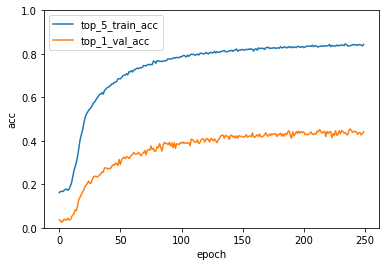

In [11]:
# Your graph
state_path=ROOT+'results/cnn_mod_final.txt'
plot_graph_pickle(state_path)


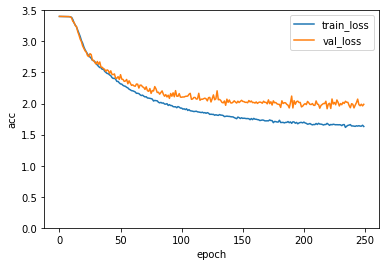

In [40]:
state_path=ROOT+'results/cnn_mod_final.txt'
plot_graph_pickle_loss(state_path)

> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [ ]:
# Your code here!
# confusion_matrix in validation sample
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve
#plot
def plot_cf_matrix(cf_matrix,output_name='output.png'):
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1))
  plt.figure(figsize = (30,30))
  sn.heatmap(df_cm, annot=True)
  plt.savefig(output_name)

def gen_cf_matrix(net,results_path,data_loader):
  #load weight
  net.load_state_dict(torch.load(results_path))
  net.eval()
  out_result=torch.tensor(())
  out_labels=torch.tensor(())
  for data in data_loader:
    inputs, labels = data
    outputs=net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    # print(outputs.shape,labels.shape)
    out_result=torch.cat((out_result,predicted),0)
    out_labels=torch.cat((out_labels,labels),0)
  cf_matrix=confusion_matrix(out_result,out_labels)
  return out_result,out_labels,cf_matrix
#cnn weight
results_path_cnn = ROOT+'results/cnnclassifier10epochs.pt'
net=CNN()
out_result,out_labels,df_cm_cnn_val=gen_cf_matrix(net,results_path_cnn,train_loader)
plot_cf_matrix(df_cm_cnn_val,'cnn_train_cf_matrix.png')

KeyboardInterrupt: ignored

In [34]:
#topk_test
results_path_cnn_mod = ROOT+'results/cnn_mod.pt'
cnn_1.load_state_dict(torch.load(results_path_cnn_mod,map_location=torch.device('cpu')))
cnn_1.eval()
for data in val_loader:
  imgs,labels=data
  outputs=cnn_1(imgs)
  # res=topk_accuracy(outputs,labels,(5,))
  break
# res

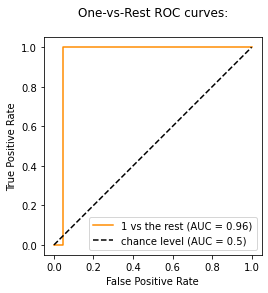

In [36]:
# ROC test
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer().fit(labels)
labels_onehot=label_binarizer.transform(labels)
predect_1=outputs.detach().numpy()
class_id=0
RocCurveDisplay.from_predictions(
    labels_onehot[:, class_id],
    predect_1[:, class_id],
    name=f"1 vs the rest",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n")
plt.legend()
plt.show()

In [ ]:
# from sklearn.metrics import RocCurveDisplay
# RocCurveDisplay.from_predictions(
#     y_onehot_test[:, class_id],
#     y_score[:, class_id],
#     name=f"{class_of_interest} vs the rest",
#     color="darkorange",
# )
# lr_fpr, lr_tpr, _ = roc_curve(out_result,out_labels)
out_result[1]

tensor(10.)

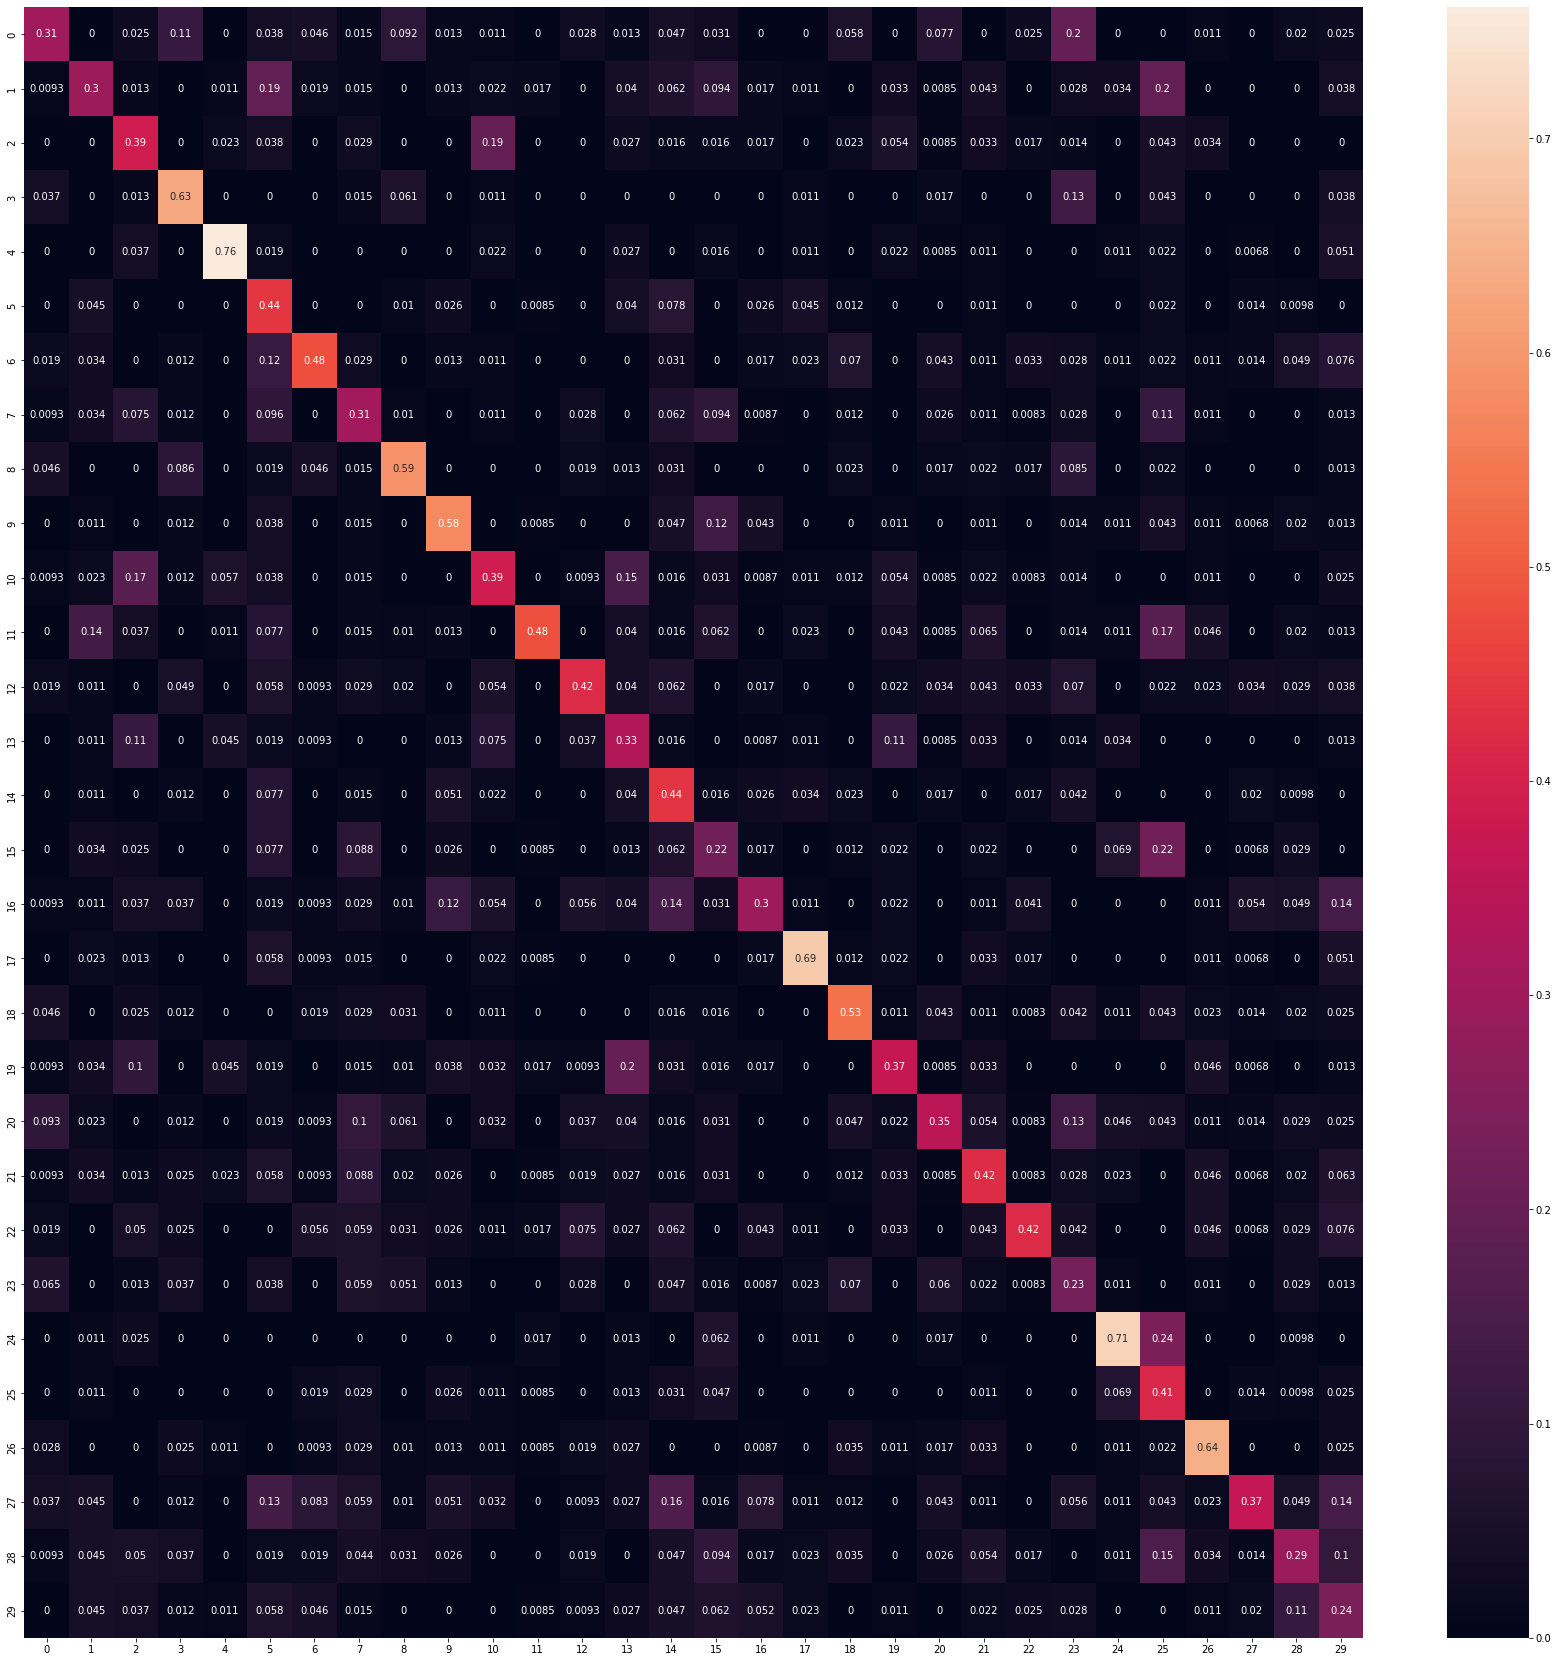

In [ ]:
#cnn weight
results_path_cnn = ROOT+'results/cnnclassifier10epochs.pt'
net=CNN()
_,_,df_cm_cnn_val=gen_cf_matrix(net,results_path_cnn,val_loader)
plot_cf_matrix(df_cm_cnn_val,'cnn_val_cf_matrix.png')

In [ ]:
# df_cm_cnn_val
np.sum(np.sum(df_cm_cnn_val, axis=1))

31.873648184818073

**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


In [ ]:
# Your code here!

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [ ]:
# Your code here!
# TO COMPLETE
cnn_drop=CNN()
results_path_cnn_drop = ROOT+'results/cnn_drop_classifier10epochs.pt'
# cnn_drop.load_state_dict(torch.load(results_path_cnn))
cnn_drop.train()
# print(cnn)
# freeze layer
# for param in cnn_drop.parameters():
#   param.requires_grad=False
# fine tuning
cnn_drop.layers[-1]=nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(64,30)
)
cnn_drop.load_state_dict(torch.load(results_path_cnn_drop))
cnn_drop.to(device)
# print(cnn)
# Train modified cnn
train_net(cnn_drop,train_loader,val_loader,20,True,results_path_cnn_drop)
#

epoch: 0 training loss:  2.003 training accuracy:  41.1%  val loss:  1.963 val accuracy:  41.9%
epoch: 1 training loss:  1.964 training accuracy:  42.1%  val loss:  1.985 val accuracy:  43.5%
epoch: 2 training loss:  1.976 training accuracy:  41.8%  val loss:  1.937 val accuracy:  42.4%
epoch: 3 training loss:  1.965 training accuracy:  43.0%  val loss:  1.979 val accuracy:  42.4%
epoch: 4 training loss:  1.962 training accuracy:  42.6%  val loss:  1.998 val accuracy:  42.0%
epoch: 5 training loss:  1.959 training accuracy:  42.4%  val loss:  1.960 val accuracy:  43.5%
epoch: 6 training loss:  1.948 training accuracy:  43.3%  val loss:  2.017 val accuracy:  41.7%
epoch: 7 training loss:  1.926 training accuracy:  43.6%  val loss:  2.040 val accuracy:  41.7%
epoch: 8 training loss:  1.946 training accuracy:  43.2%  val loss:  2.019 val accuracy:  41.7%
epoch: 9 training loss:  1.945 training accuracy:  42.7%  val loss:  2.003 val accuracy:  43.3%
epoch: 10 training loss:  1.930 training

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [37]:
# Your code here!
# 0.1
results_path_cnn_mod_lr = ROOT+'results/cnn_mod_lr.pt'
state_path_cnn_mod_lr_1 = ROOT+'results/cnn_mod_lr_1.txt'
cnn_1.load_state_dict(torch.load(results_path_cnn_mod))
cnn_1.train()
train_net(cnn_1,train_loader,val_loader,10,True,results_path_cnn_mod_lr,True,True,state_path_cnn_mod_lr_1,0.1)

epoch: 0 training loss:  3.434 training accuracy:  16.7%  val loss:  3.419 val accuracy:  17.2%
epoch: 1 training loss:  3.416 training accuracy:  17.1%  val loss:  3.409 val accuracy:  17.7%
epoch: 2 training loss:  3.418 training accuracy:  16.2%  val loss:  3.411 val accuracy:  17.3%
epoch: 3 training loss:  3.419 training accuracy:  16.0%  val loss:  3.411 val accuracy:  16.7%
epoch: 4 training loss:  3.417 training accuracy:  16.5%  val loss:  3.426 val accuracy:  14.8%
epoch: 5 training loss:  3.416 training accuracy:  15.7%  val loss:  3.425 val accuracy:  16.6%
epoch: 6 training loss:  3.418 training accuracy:  16.1%  val loss:  3.415 val accuracy:  16.8%
epoch: 7 training loss:  3.418 training accuracy:  16.0%  val loss:  3.411 val accuracy:  17.1%
epoch: 8 training loss:  3.417 training accuracy:  16.2%  val loss:  3.426 val accuracy:  15.2%
epoch: 9 training loss:  3.417 training accuracy:  16.6%  val loss:  3.418 val accuracy:  16.5%


In [38]:
# Your code here!
# 0.001
results_path_cnn_mod_lr_2 = ROOT+'results/cnn_mod_lr_2.pt'
state_path_cnn_mod_lr_2 = ROOT+'results/cnn_mod_lr_2.txt'
cnn_1.load_state_dict(torch.load(results_path_cnn_mod))
cnn_1.train()
train_net(cnn_1,train_loader,val_loader,10,True,results_path_cnn_mod_lr_2,True,True,state_path_cnn_mod_lr_2,0.001)

epoch: 0 training loss:  1.641 training accuracy:  84.1%  val loss:  1.781 val accuracy:  80.8%
epoch: 1 training loss:  1.649 training accuracy:  83.7%  val loss:  1.812 val accuracy:  80.6%
epoch: 2 training loss:  1.656 training accuracy:  84.0%  val loss:  1.829 val accuracy:  80.5%
epoch: 3 training loss:  1.647 training accuracy:  83.7%  val loss:  1.797 val accuracy:  80.4%
epoch: 4 training loss:  1.644 training accuracy:  84.1%  val loss:  1.786 val accuracy:  80.8%
epoch: 5 training loss:  1.642 training accuracy:  83.7%  val loss:  1.805 val accuracy:  80.7%
epoch: 6 training loss:  1.656 training accuracy:  83.9%  val loss:  1.852 val accuracy:  79.7%
epoch: 7 training loss:  1.653 training accuracy:  83.8%  val loss:  1.863 val accuracy:  79.7%
epoch: 8 training loss:  1.643 training accuracy:  83.8%  val loss:  1.796 val accuracy:  80.2%
epoch: 9 training loss:  1.641 training accuracy:  83.8%  val loss:  1.866 val accuracy:  79.8%


In [39]:
# Your code here!
# 0.0001
results_path_cnn_mod_lr_3 = ROOT+'results/cnn_mod_lr_3.pt'
state_path_cnn_mod_lr_3 = ROOT+'results/cnn_mod_lr_3.txt'
cnn_1.load_state_dict(torch.load(results_path_cnn_mod))
cnn_1.train()
train_net(cnn_1,train_loader,val_loader,10,True,results_path_cnn_mod_lr_3,True,True,state_path_cnn_mod_lr_3,0.0001)

epoch: 0 training loss:  1.577 training accuracy:  85.2%  val loss:  1.707 val accuracy:  83.0%
epoch: 1 training loss:  1.549 training accuracy:  86.0%  val loss:  1.710 val accuracy:  82.6%
epoch: 2 training loss:  1.558 training accuracy:  86.0%  val loss:  1.733 val accuracy:  81.8%
epoch: 3 training loss:  1.557 training accuracy:  85.4%  val loss:  1.721 val accuracy:  82.0%
epoch: 4 training loss:  1.552 training accuracy:  86.0%  val loss:  1.708 val accuracy:  82.8%
epoch: 5 training loss:  1.553 training accuracy:  85.6%  val loss:  1.717 val accuracy:  82.2%
epoch: 6 training loss:  1.551 training accuracy:  85.5%  val loss:  1.695 val accuracy:  82.3%
epoch: 7 training loss:  1.553 training accuracy:  85.4%  val loss:  1.724 val accuracy:  83.1%
epoch: 8 training loss:  1.537 training accuracy:  85.4%  val loss:  1.703 val accuracy:  82.6%
epoch: 9 training loss:  1.539 training accuracy:  86.0%  val loss:  1.693 val accuracy:  82.9%


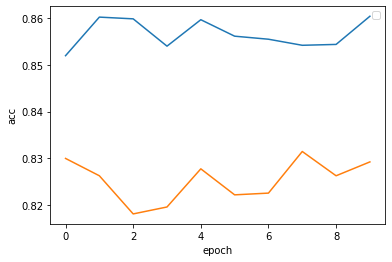

In [51]:
# Your graph
state_path_cnn_mod_lr_2 = ROOT+'results/cnn_mod_lr_2.txt'
plot_graph_pickle(state_path_cnn_mod_lr_2)

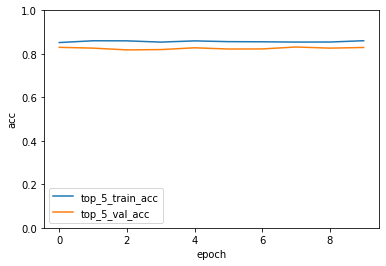

In [14]:
#
state_path_cnn_mod_lr_2 = ROOT+'results/cnn_mod_lr_2.txt'
plot_graph_pickle(state_path_cnn_mod_lr_2)

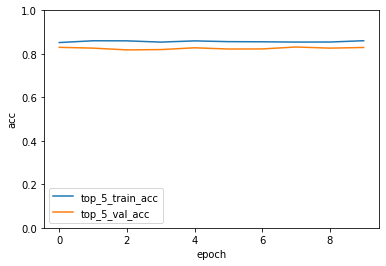

In [13]:
state_path_cnn_mod_lr_3 = ROOT+'results/cnn_mod_lr_3.txt'
plot_graph_pickle(state_path_cnn_mod_lr_3)

### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [15]:
# Your code here!
# Define your own class LoadFromFolder
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
      # Set the loading directory
      self.main_dir = main_dir
      self.transform = transform
        
      # List all images in folder and count them
      all_imgs = os.listdir(main_dir)
      self.total_imgs = natsorted(all_imgs)
    def __len__(self):
      # Return the previously computed number of images
      return len(self.total_imgs)
    def __getitem__(self, idx):
      img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
      
      # Use PIL for image loading
      image = Image.open(img_loc).convert("RGB")
      # Apply the transformations
      tensor_image = self.transform(image)
      return tensor_image

In [ ]:
dataset = LoadFromFolder(main_dir="./data", transform=transform)
dataloader = DataLoader(dataset)
print(next(iter(dataloader)).shape)  # prints shape of image with single batch

#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [58]:
# Your code here!
# write csv file for kaggle  
import csv
import os,sys
from torchvision.io.image import read_image
file_dir=ROOT+"test_set/test_set"
dirs=os.listdir(file_dir)
#load cnn_1
# cnn_1.load_state_dict(torch.load(results_path_cnn_mod))
cnn_1.load_state_dict(torch.load(results_path_cnn_mod_lr))
cnn_1.eval()
net=cnn_1
# load alex
# net=AlexNet_froze_30_device
# net.eval()
# load cnn_drop
# cnn_drop.load_state_dict(torch.load(results_path_cnn_drop))
# cnn_drop.eval()
# net=cnn_drop
# load cnn
# results_path_cnn = ROOT+'results/cnnclassifier10epochs.pt'
# cnn=CNN()
# cnn.load_state_dict(torch.load(results_path_cnn))
# cnn.eval()
# net=cnn
# cnn.to(device)

with open(ROOT+"results/sc22qh.csv",'w') as f:
  # writer=csv.writer(f)
  # writer.writerow("Id,Category")
  f.write("Id,Category\n")

for img_dir in dirs:
  img=read_image(file_dir+'/'+img_dir)
  img=torch.tensor(img,dtype=torch.float32)
  img=img.unsqueeze(0)
  img=img.to(device)
  
  # # img=img.to(device)
  # print(img.shape)

  try:
    outputs=net(img)
    
  except:
    img=img.repeat(1,3,1,1)
    outputs=net(img)
    # print(img.shape)
    # Category=1
  _, Category = torch.max(outputs.data, 1)
  Category=Category.item()
  # print(Category)
  with open(ROOT+"results/sc22qh.csv",'a') as f:
    # writer=csv.writer(f)
    # writer.writerow(img_dir+','+str(Category))
    f.write(img_dir+','+str(Category)+'\n')
  # break


<ipython-input-58-aae4c3290744>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img=torch.tensor(img,dtype=torch.float32)


In [ ]:
len(dirs)

1500

In [ ]:
cnn(img)

RuntimeError: ignored

In [ ]:
torch.tensor(img,dtype=torch.float32)

<ipython-input-109-361a2370c2c3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img,dtype=torch.float32)


tensor([[[ 77.,  75.,  72.,  ...,  65.,  71.,  83.],
         [ 74.,  72.,  70.,  ...,  65.,  68.,  78.],
         [ 72.,  70.,  68.,  ...,  62.,  62.,  67.],
         ...,
         [112., 106.,  91.,  ..., 108., 149., 135.],
         [108., 119., 117.,  ..., 109., 114.,  99.],
         [108., 121., 120.,  ...,  70.,  57.,  74.]],

        [[ 88.,  86.,  83.,  ...,  78.,  84.,  97.],
         [ 85.,  83.,  81.,  ...,  78.,  81.,  91.],
         [ 84.,  82.,  80.,  ...,  74.,  74.,  79.],
         ...,
         [130., 124., 109.,  ..., 112., 153., 139.],
         [127., 138., 135.,  ..., 109., 114.,  98.],
         [127., 140., 139.,  ...,  69.,  56.,  73.]],

        [[ 10.,   8.,   5.,  ...,   0.,   2.,  12.],
         [  6.,   4.,   2.,  ...,   0.,   1.,  11.],
         [  2.,   0.,   0.,  ...,   2.,   2.,   7.],
         ...,
         [  8.,   2.,   0.,  ...,  17.,  58.,  44.],
         [  2.,  13.,  13.,  ...,  23.,  28.,  15.],
         [  1.,  14.,  14.,  ...,   0.,   0.,   0.]]]

In [ ]:
3*64*64

12288


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [25]:
import torchvision
# Your code here! 
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])
trnsfrm_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64))
])
# Load the datasets
train_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=True,
    download=True,
    transform=trnsfrm
)

test_set = torchvision.datasets.CIFAR10(
    root=ROOT+'data',
    train=False,
    download=True,
    transform=trnsfrm_test
)

train_loader_10 = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader_10 = torch.utils.data.DataLoader(
    test_set,
    batch_size=24, # Forward pass only so batch size can be larger
    shuffle=False,
    num_workers=2
)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
img=next(iter(train_loader_10))
img[0].shape

torch.Size([16, 3, 32, 32])

In [ ]:
# for data in train_loader_10:
#   input,labels=data
#   input=input.to(device)
#   print(input.shape)
#   result=AlexNet_device(input)
#   print(result)
#   break

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Your code here! 
AlexNet=torchvision.models.alexnet(weights=True)
AlexNet_froze=torchvision.models.alexnet(weights=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
AlexNet_froze_30=torchvision.models.alexnet(weights=True)

In [ ]:
# import copy
# AlexNet_froze=copy.deepcopy(AlexNet)

In [ ]:
# for param in AlexNet.parameters():
#   print(param.requires_grad)
# print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAfroze")
# for param in AlexNet_froze.features.parameters():
#   print(param.requires_grad)
for param in AlexNet_froze.features.parameters():
  param.requires_grad=False
# print("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
# for param in AlexNet_froze.parameters():
#   print(param.requires_grad)

AlexNet_froze.classifier[6]=nn.Linear(in_features=4096, out_features=10, bias=True)
AlexNet.classifier[6]=nn.Linear(in_features=4096, out_features=10, bias=True)

print(AlexNet_froze)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(AlexNet_froze.parameters)
print(AlexNet.parameters)

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [ ]:
# Your model changes here - also print trainable parameters

#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [19]:

# Show param before froze
AlexNet_device=AlexNet.to(device)
summary(AlexNet_device,(3,64,64))
# for name, param in AlexNet_device.named_parameters():
#     if param.requires_grad==False:
#         print(name,param.data.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# Your changes here - also print trainable parameters
# Show param after froze
AlexNet_froze_device=AlexNet_froze.to(device)
# summary(AlexNet_froze_device,(3,64,64))
for name, param in AlexNet_froze_device.named_parameters():
    if param.requires_grad==False:
        print(name,param.data.shape)

features.0.weight torch.Size([64, 3, 11, 11])
features.0.bias torch.Size([64])
features.3.weight torch.Size([192, 64, 5, 5])
features.3.bias torch.Size([192])
features.6.weight torch.Size([384, 192, 3, 3])
features.6.bias torch.Size([384])
features.8.weight torch.Size([256, 384, 3, 3])
features.8.bias torch.Size([256])
features.10.weight torch.Size([256, 256, 3, 3])
features.10.bias torch.Size([256])


#### 4.3 Compare above configurations and comment on comparative performance

In [ ]:
# Your graphs here and please provide comment in markdown in another cell\
# Train AlexNet
results_path_AlexNet=ROOT+'results/AlexNet_classifier10epochs.pt'
AlexNet_device.load_state_dict(torch.load(results_path_AlexNet))
train_net(AlexNet_device,train_loader_10,test_loader_10,10,True,results_path_AlexNet)

epoch: 0 training loss:  1.063 training accuracy:  62.8%  val loss:  0.896 val accuracy:  69.5%
epoch: 1 training loss:  0.962 training accuracy:  66.3%  val loss:  0.825 val accuracy:  71.3%
epoch: 2 training loss:  0.899 training accuracy:  68.8%  val loss:  0.739 val accuracy:  74.4%
epoch: 3 training loss:  0.850 training accuracy:  70.3%  val loss:  0.789 val accuracy:  73.3%
epoch: 4 training loss:  0.812 training accuracy:  71.8%  val loss:  0.731 val accuracy:  75.0%
epoch: 5 training loss:  0.779 training accuracy:  72.9%  val loss:  0.682 val accuracy:  76.6%
epoch: 6 training loss:  0.749 training accuracy:  73.7%  val loss:  0.681 val accuracy:  76.3%
epoch: 7 training loss:  0.727 training accuracy:  74.7%  val loss:  0.637 val accuracy:  78.5%
epoch: 8 training loss:  0.703 training accuracy:  75.4%  val loss:  0.656 val accuracy:  77.5%
epoch: 9 training loss:  0.677 training accuracy:  76.4%  val loss:  0.632 val accuracy:  78.4%


In [ ]:
#Train AlexNet_froze
results_path_AlexNet_froze=ROOT+'results/AlexNet_froze_classifier10epochs.pt'
AlexNet_froze_device.load_state_dict(torch.load(results_path_AlexNet_froze))
# AlexNet_froze_device.eval()
train_net(AlexNet_froze_device,train_loader_10,test_loader_10,10,True,results_path_AlexNet_froze)

epoch: 0 training loss:  1.638 training accuracy:  41.8%  val loss:  1.409 val accuracy:  50.1%
epoch: 1 training loss:  1.511 training accuracy:  46.0%  val loss:  1.347 val accuracy:  51.9%
epoch: 2 training loss:  1.460 training accuracy:  47.7%  val loss:  1.321 val accuracy:  53.0%
epoch: 3 training loss:  1.441 training accuracy:  48.6%  val loss:  1.297 val accuracy:  53.8%
epoch: 4 training loss:  1.430 training accuracy:  48.9%  val loss:  1.298 val accuracy:  54.0%
epoch: 5 training loss:  1.410 training accuracy:  49.6%  val loss:  1.293 val accuracy:  53.9%
epoch: 6 training loss:  1.405 training accuracy:  50.0%  val loss:  1.289 val accuracy:  53.8%
epoch: 7 training loss:  1.397 training accuracy:  50.3%  val loss:  1.266 val accuracy:  55.0%
epoch: 8 training loss:  1.383 training accuracy:  51.1%  val loss:  1.267 val accuracy:  55.4%
epoch: 9 training loss:  1.374 training accuracy:  50.9%  val loss:  1.254 val accuracy:  55.4%


### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [ ]:
# Your code here! 
# for param in AlexNet_froze_30.features.parameters():
#   param.requires_grad=False
AlexNet_froze_30.classifier[6]=nn.Linear(in_features=4096, out_features=30, bias=True)

# print(AlexNet_froze_30)
AlexNet_froze_30_device=AlexNet_froze_30.to(device)
AlexNet_froze_30_device.train()
results_path_AlexNet_froze_30=ROOT+'results/AlexNet_froze_30_classifier10epochs.pt'
AlexNet_froze_30_device.load_state_dict(torch.load(results_path_AlexNet_froze_30))
train_net(AlexNet_froze_30_device,train_loader,val_loader,50,True,results_path_AlexNet_froze_30)

epoch: 0 training loss:  1.267 training accuracy:  61.2%  val loss:  1.765 val accuracy:  50.3%
epoch: 1 training loss:  1.233 training accuracy:  62.5%  val loss:  1.801 val accuracy:  50.5%
epoch: 2 training loss:  1.180 training accuracy:  64.1%  val loss:  1.702 val accuracy:  51.4%
epoch: 3 training loss:  1.138 training accuracy:  65.5%  val loss:  1.725 val accuracy:  51.9%
epoch: 4 training loss:  1.117 training accuracy:  65.5%  val loss:  1.762 val accuracy:  51.7%
epoch: 5 training loss:  1.092 training accuracy:  66.6%  val loss:  1.796 val accuracy:  52.0%
epoch: 6 training loss:  1.053 training accuracy:  67.4%  val loss:  1.704 val accuracy:  53.4%
epoch: 7 training loss:  1.006 training accuracy:  68.6%  val loss:  1.864 val accuracy:  51.3%
epoch: 8 training loss:  0.994 training accuracy:  69.4%  val loss:  1.799 val accuracy:  51.2%
epoch: 9 training loss:  0.955 training accuracy:  70.2%  val loss:  1.840 val accuracy:  52.6%
epoch: 10 training loss:  0.958 training

KeyboardInterrupt: ignored

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


In [ ]:
# Your code here! 


### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [23]:
# Your code here!
!pip install torchcam
from torchcam.methods import SmoothGradCAMpp
import torchvision
results_path_AlexNet=ROOT+'results/AlexNet_classifier10epochs.pt'
AlexNet=torchvision.models.alexnet(weights=True)
AlexNet.classifier[6]=nn.Linear(in_features=4096, out_features=10, bias=True)
# AlexNet_device=AlexNet.to(device)
AlexNet_device.load_state_dict(torch.load(results_path_AlexNet,map_location=torch.device('cpu')))
AlexNet_device.eval()
cam_extractor = SmoothGradCAMpp(AlexNet_device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
# Your code here!
from torchvision.transforms.functional import normalize, resize, to_pil_image
img=next(iter(train_loader_10))[0][0]
img=img.to(device)
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_tensor.shape
# img_show=np.transpose(img.numpy(),(1,2,0))
# plt.imshow(img_show)
# plt.axis('off')
# plt.show()

torch.Size([3, 224, 224])

In [27]:
# Your code here!
# with SmoothGradCAMpp(AlexNet_device) as cam_extractor:
#   # Preprocess your data and feed it to the model
#   out = AlexNet_device(input_tensor.unsqueeze(0))
#   # Retrieve the CAM by passing the class index and the model output
#   activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
out = AlexNet_device(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
activation_map

[tensor([[[0.4144, 0.1557, 0.0000, 0.0634, 0.0844, 0.9281],
          [0.1618, 0.0962, 0.1105, 0.0978, 0.0672, 0.1485],
          [0.0918, 0.1756, 0.1949, 0.1831, 0.1005, 0.1891],
          [0.2055, 0.2258, 0.1608, 0.1305, 0.0978, 0.2468],
          [0.7404, 0.8557, 0.6080, 0.3522, 0.4743, 0.7076],
          [1.0000, 0.7385, 0.5395, 0.4528, 0.6463, 0.9085]]])]

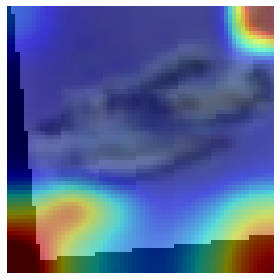

In [28]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

In [ ]:
activation_map

[tensor([[[nan, nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan, nan],
          [nan, nan, nan, nan, nan, nan]]], device='cuda:0')]

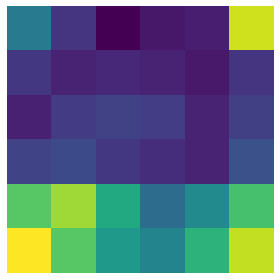

In [29]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].cpu().squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

>a)The hotmap focus on the background instead of the object and therefore got the wrong result

>b)Use a better network structure and train the network again


**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
